# Note: this file using predefined models for simplicity

# CIFAR-10: Training and Testing on a Clean Dataset & Adversarial Analysis

## Imports and CIFAR-10 loading

In [1]:
# For loading model sanely
import os.path

# For plotting
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as DataUtils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.notebook import tnrange, tqdm

import models.resnet as resnet

In [2]:
# Define the `device` PyTorch will be running on, please hope it is CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Notebook will use PyTorch Device: " + device.upper())

Notebook will use PyTorch Device: CUDA


In [3]:
DATA_ROOT = "./datasets/"


def get_CIFAR10_data_loaders(
    batchSize=64, trainSetSize=50000, validationSetSize=10000, testSetSize=10000
):

    # Create a separate transform for each dataset
    # (in case we decide to transform differently)
    trainSetTransform = transforms.Compose([transforms.ToTensor()])
    validationSetTransform = transforms.Compose([transforms.ToTensor()])
    testSetTransform = transforms.Compose([transforms.ToTensor()])

    # Download the dataset (note we technically use the same set for validation
    # and training)
    trainSet = datasets.CIFAR10(
        root=DATA_ROOT, download=True, train=True, transform=trainSetTransform
    )
    validationSet = datasets.CIFAR10(
        root=DATA_ROOT, download=True, train=True, transform=validationSetTransform
    )
    testSet = datasets.CIFAR10(
        root=DATA_ROOT, download=True, train=False, transform=testSetTransform
    )

    # Get the training indices to split into training and validation sets
    indices = np.arange(0, trainSetSize + validationSetSize)
    np.random.shuffle(indices)

    # Construct random samplers (for better training)
    trainSetSampler = SubsetRandomSampler(indices[:trainSetSize])
    validationSetSampler = SubsetRandomSampler(indices[trainSetSize:])
    testSetSampler = SubsetRandomSampler(np.arange(0, testSetSize))

    # Finally, construct the loaders that will be used to get images
    trainSetLoader = DataUtils.DataLoader(
        trainSet, batch_size=batchSize, sampler=trainSetSampler
    )
    validationSetLoader = DataUtils.DataLoader(
        validationSet, batch_size=batchSize, sampler=validationSetSampler
    )
    testSetLoader = DataUtils.DataLoader(
        testSet, batch_size=batchSize, sampler=testSetSampler
    )

    # Return the loaders
    return trainSetLoader, validationSetLoader, testSetLoader

## Training, Validation and Testing

In [4]:
# Get the data loaders (assume we do no validation)
trainSetLoader, _, testSetLoader = get_CIFAR10_data_loaders(
    trainSetSize=50000, validationSetSize=0
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# This method creates a new model and also trains it
def get_trained_model(load_if_available=False):
    # Various training parameters
    epochs = 60
    learning_rate = 0.01

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = resnet.ResNet50()
    model = model.to(device)
    model.train()

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    # If a trained model already exists, give up the training part
    if load_if_available and os.path.isfile("./cifar10_model"):
        print("Found already trained model")

        model = torch.load("./cifar10_model")

        # Return the loaded model
        return model, loss_function, optimizer

    print("Training the model...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images)

            loss = loss_function(logits, labels)
            loss.backward()

            optimizer.step()

    print("... done!")

    # Return the trained model
    return model, loss_function, optimizer

In [6]:
# This method tests a given mode and prints the accuracy of that model
def test_trained_model(model):
    correct = 0

    print("Testing the model...")

    # Use a pretty progress bar to show updates
    for j, (images, labels) in enumerate(tqdm(testSetLoader, desc="Testing Progress")):
        # Cast to proper tensor
        images, labels = images.to(device), labels.to(device)

        # Predict
        logits = model(images)

        # The highest class represents the chosen class
        _, preds = torch.max(logits, 1)
        correct += (preds == labels).sum().item()

    print("... done! Accuracy: {}%".format(float(correct) * 100 / 10000))

## Putting it all together (the 'main')

In [7]:
model, loss_function, optimizer = get_trained_model(load_if_available=True)

test_trained_model(model)

Found already trained model
Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 83.33%


In [8]:
# Save the model
torch.save(model, "./cifar10_model")

In [9]:
# Load and test the loaded model (shortcutting many steps)
model = torch.load("./cifar10_model")

test_trained_model(model)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 83.23%


## Attacks and Their Results

### Helper functions

In [10]:
def attack_model(model, loss_function, attack, epsilon, alpha):
    # Network parameters
    loss_function = nn.CrossEntropyLoss()

    correct = 0

    print("Testing the model using epsilon = {}, alpha = {}...".format(epsilon, alpha))

    # Use a pretty progress bar to show updates
    for j, (images, labels) in enumerate(
        tqdm(testSetLoader, desc="Attack Testing Progress")
    ):
        # Cast to proper tensor
        images, labels = images.to(device), labels.to(device)

        # Perturb the images using the I-FGSM attack
        perturbed_images = attack(
            images,
            labels,
            model,
            loss_function,
            epsilon=epsilon,
            alpha=alpha,
            scale=True,
        )

        # Calculate results
        logits = model(perturbed_images)

        _, preds = torch.max(logits, 1)

        correct += (preds == labels).sum().item()

    print("... done! Accuracy: {}%\n\n".format(float(correct) * 100 / 10000))

In [11]:
def print_image(image, title, plot):
    numpy_image = image.numpy()
    plot.imshow(np.transpose(numpy_image, (1, 2, 0)))
    plot.set_title(title)

In [12]:
def print_attack(model, loss_function, attack, epsilon, alpha):
    # Print 3 random images and the perturbed counterparts
    number_of_images = 3

    # This is becase for each image, we want to also print the perturbed image
    number_columns = 2

    # Subplot(r,c) provide the number of rows and columns
    figure, axarr = plt.subplots(
        number_of_images,
        number_columns,
        figsize=(2 * number_columns, 2.5 * number_of_images),
    )
    figure.subplots_adjust(hspace=1)
    figure.suptitle("Attack using epsilon = {}".format(epsilon))

    # We only want correct images so we can show the attack works
    current_image = 0

    # Select the images and show the noise
    while True:
        # Get random image index
        index = np.random.randint(0, len(testSetLoader.dataset))

        # Get an image and cast it to CUDA if needed, cast to proper batches
        image, label = testSetLoader.dataset[index]
        image = image[None, :]
        label = torch.as_tensor((label,))

        image, label = image.to(device), label.to(device)

        # Predict
        logits = model(image)
        _, pred = torch.max(logits, 1)

        # Check for correct image classification
        if pred != label:
            continue

        # Call the attack
        perturbed_image = attack(
            image,
            label,
            model,
            loss_function,
            epsilon=epsilon,
            alpha=alpha,
            scale=True,
        )

        # Calculate results
        logits = model(perturbed_image)
        _, fgsm_pred = torch.max(logits, 1)

        pred = pred.cpu().detach()[0]
        fgsm_pred = fgsm_pred.cpu().detach()[0]

        # Get the plots
        image_plot = axarr[current_image, 0]
        perturbed_image_plot = axarr[current_image, 1]

        # Print the original image
        print_image(
            torchvision.utils.make_grid(image.cpu().data, normalize=True),
            f"Predicted {testSetLoader.dataset.classes[pred]}",
            image_plot,
        )

        # Print the perturbed iamge
        print_image(
            torchvision.utils.make_grid(perturbed_image.cpu().data, normalize=True),
            f"Predicted {testSetLoader.dataset.classes[fgsm_pred]}",
            perturbed_image_plot,
        )

        # Processed a good image, go forward
        current_image += 1

        # Stop at one point
        if current_image >= number_of_images:
            break

### FGSM (Fast Sign Gradient Method) https://arxiv.org/abs/1412.6572

The formula that is used for producing the adversarial example in this case is:

$x' = x + \epsilon * sign(\nabla_{x}J(\theta, x, y))$, where J is the loss function used.

In [13]:
import attacks.fgsm as fgsm

In [14]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1, 5]

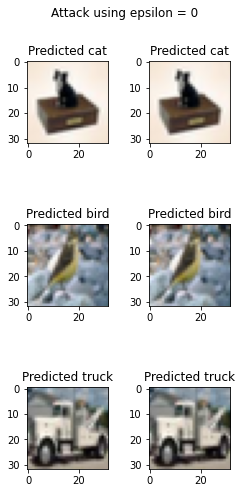

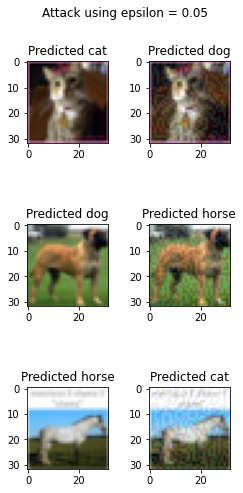

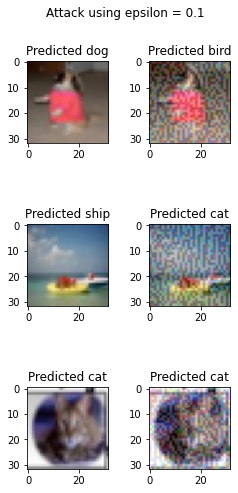

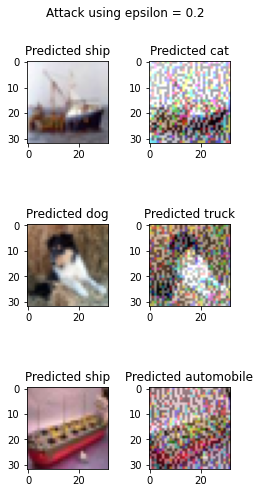

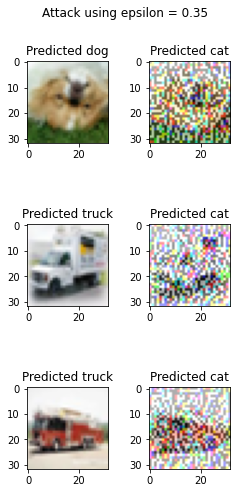

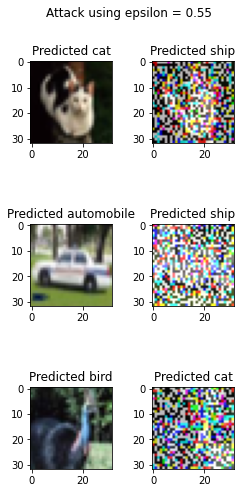

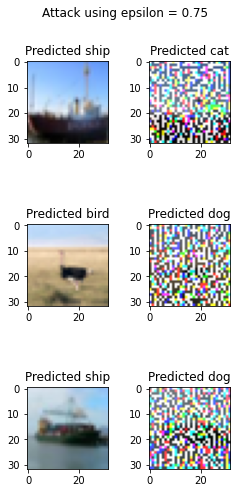

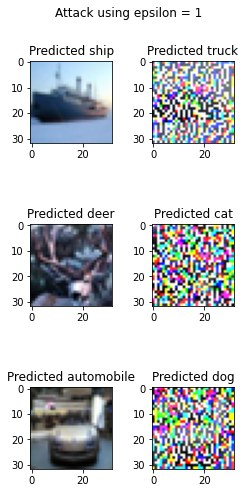

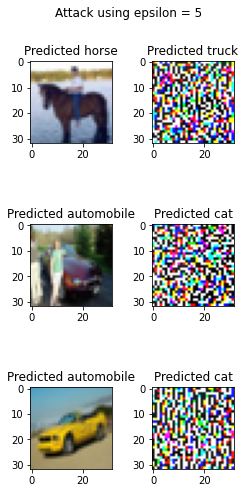

In [15]:
for epsilon in epsilons:
    print_attack(model, loss_function, fgsm.fgsm_attack, epsilon=epsilon, alpha=None)

In [16]:
# Run test for each epsilon
for epsilon in epsilons:
    attack_model(model, loss_function, fgsm.fgsm_attack, epsilon=epsilon, alpha=None)

Testing the model using epsilon = 0, alpha = None...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 82.94%


Testing the model using epsilon = 0.05, alpha = None...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 36.2%


Testing the model using epsilon = 0.1, alpha = None...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 29.96%


Testing the model using epsilon = 0.2, alpha = None...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 22.83%


Testing the model using epsilon = 0.35, alpha = None...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 18.24%


Testing the model using epsilon = 0.55, alpha = None...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 13.11%


Testing the model using epsilon = 0.75, alpha = None...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 12.02%


Testing the model using epsilon = 1, alpha = None...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 10.63%


Testing the model using epsilon = 5, alpha = None...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 9.46%




### I-FGSM / BIM (Iterative FGSM / Basic Iterative Method) https://arxiv.org/abs/1607.02533

The formula that is used for producing the adversarial example in this case is:

$x'_{0} = x$
$x'_{k + 1} = Clip_{x, \epsilon} \{x'_{k} + \alpha * sign(\nabla_{x}J(\theta, x'_{k}, y)\}$, where J is the loss function used. Note that in the paper proposing this method, $\alpha = 1$ is used, so pixels are changed by 1 in each iteration.

The formula for the clip function is also given in the paper.

In [17]:
import attacks.ifgsm as ifgsm

In [18]:
# Several values for epsilon. It's interesting to see how clamping affects results
epsilons = [0.25, 0.5, 0.75, 1, 2, 3, 4]

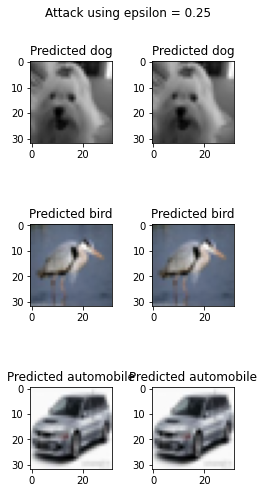

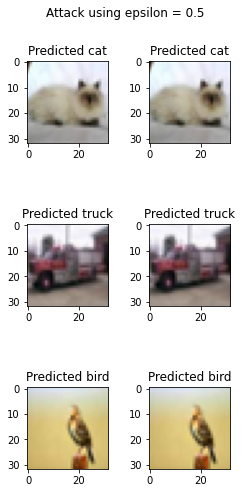

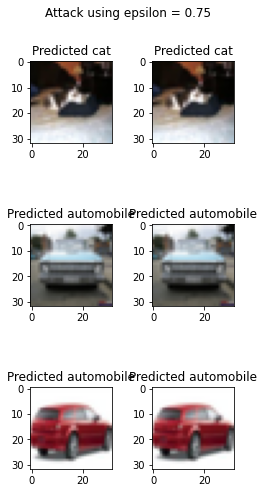

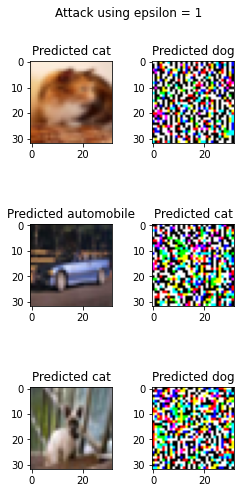

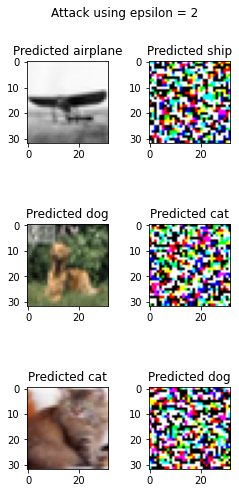

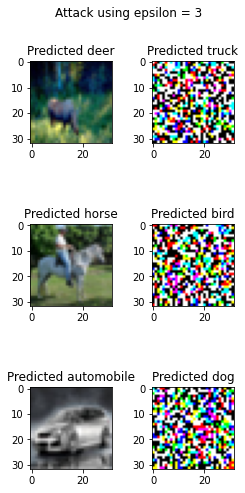

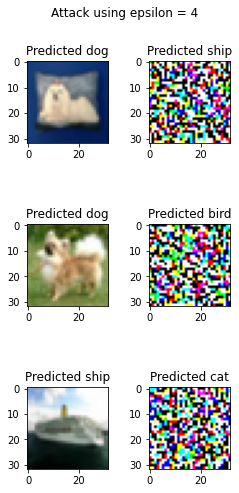

In [19]:
for epsilon in epsilons:
    print_attack(model, loss_function, ifgsm.ifgsm_attack, epsilon=epsilon, alpha=1)

In [20]:
for epsilon in epsilons:
    attack_model(model, loss_function, ifgsm.ifgsm_attack, epsilon=epsilon, alpha=1)

Testing the model using epsilon = 0.25, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 83.21%


Testing the model using epsilon = 0.5, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 83.05%


Testing the model using epsilon = 0.75, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 83.09%


Testing the model using epsilon = 1, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 8.44%


Testing the model using epsilon = 2, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 2.11%


Testing the model using epsilon = 3, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 2.42%


Testing the model using epsilon = 4, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 2.44%




### PGD (Projected Gradient Descent) https://arxiv.org/pdf/1706.06083.pdf

The formula that is used for producing the adversarial example in this case is:

$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$\n
where S is a set of allowed perturbations. Note that this is basically BIM with random initialisation. 

We use the $L_{\infty}$ norm here, i.e. we use clamping. 

In [21]:
import attacks.pgd as pgd

In [22]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.15, 0.3, 1, 2]

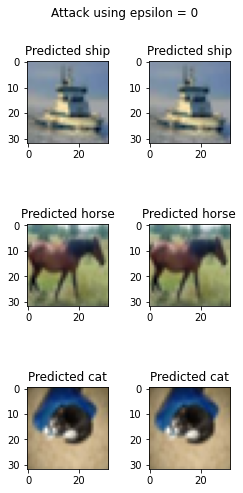

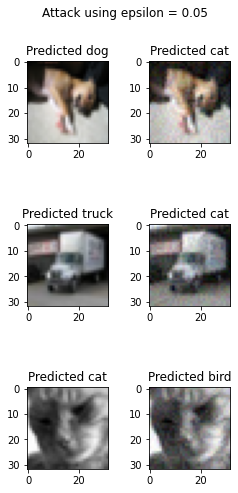

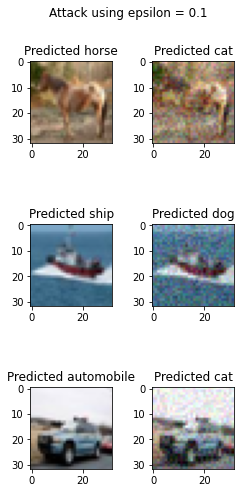

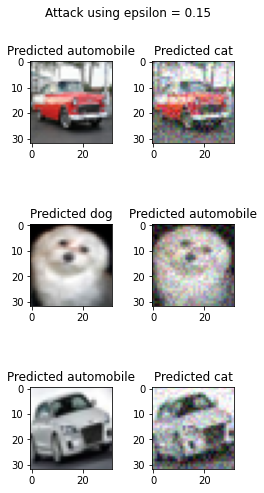

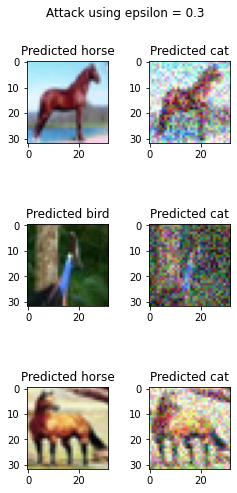

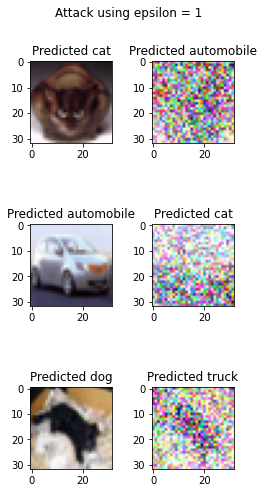

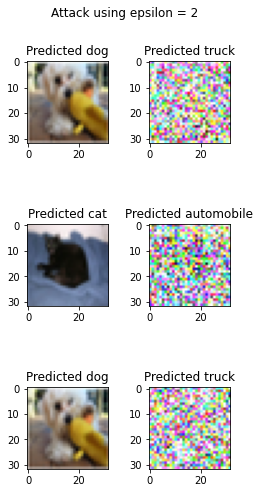

In [23]:
for epsilon in epsilons:
    print_attack(model, loss_function, pgd.pgd_attack, epsilon=epsilon, alpha=(2 / 255))

In [24]:
for epsilon in epsilons:
    attack_model(model, loss_function, pgd.pgd_attack, epsilon=epsilon, alpha=(2 / 255))

Testing the model using epsilon = 0, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 83.02%


Testing the model using epsilon = 0.05, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model using epsilon = 0.1, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model using epsilon = 0.15, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model using epsilon = 0.3, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model using epsilon = 1, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model using epsilon = 2, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


